# Test of flagman performance

In this notebook we compare the improvement made by the hybrid model over the baseline.

In [1]:
from movie_lens_lib import *
import pandas as pd
from sklearn.model_selection import train_test_split

## Constants

In [2]:
n_movie_clusters = 5
rating_multiplier = 5
year_multiplier = 0.05
test_sample_size = 100_000
weight_genre, weight_cluster, weight_movie = 0.35, 0.45, 0.2
train_size = 0.9
random_state = 42

## Import & Split dataset

In [3]:
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv", index_col="movieId")

X = ratings_df.drop(["rating"], axis=1)
y = ratings_df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
ratings_train_df = pd.concat([X_train, y_train], axis=1)
ratings_test_df = pd.concat([X_test, y_test], axis=1)

## Preprocess

In [4]:
movies_hot_df = PreProcessingAggregated().transform((movies_df, ratings_train_df))

## Baseline performance
We are going to compare 3 baseline models in this section.

### Naive constant

As the first baseline we predict rating of **2.5** for every pair of USER - MOVIE.

In [5]:
y_pred = np.zeros(y_test.shape[0]) + 2.5
print_stats(naive_baseline_results := get_performance_stats(y_test, y_pred))

MSE: 2.221
MAE: 1.297
ACCURACY: 0.453


### Mean rating over the training set

In [6]:
y_pred = np.zeros(y_test.shape[0]) + y_train.mean()
print_stats(global_mean_baseline_results := get_performance_stats(y_test, y_pred))

MSE: 1.133
MAE: 0.843
ACCURACY: 0.675


### Mean rating for the movie

We have implemented the regressor for this task, and it is put into movie_lens_lib.py

In [7]:
x_test_sample = ratings_test_df.sample(frac=1, random_state=42)
x_test_sample = x_test_sample[:test_sample_size]
y_true = x_test_sample["rating"].values

movie_regressor = MovieBasedRegressor().fit(movies_hot_df)
movie_predictions = movie_regressor.predict(x_test_sample, False)
print_stats(movie_regressor_results := get_performance_stats(y_true, movie_predictions))

MSE: 0.933
MAE: 0.746
ACCURACY: 0.725


## Hybrid performance

In [8]:
x_test_sample = ratings_test_df.sample(frac=1, random_state=42)
x_test_sample = x_test_sample[:test_sample_size]
y_true = x_test_sample["rating"].values

hybrid_regressor = HybridRegressor(
    movies_hot_df,
    cluster_based_regressor = ClusterBasedRegressor(
        movies_hot_df,
        n_movie_clusters,
        rating_multiplier,
        year_multiplier,
        random_state
    )
).fit(X_train, y_train)

hybrid_predictions = hybrid_regressor.predict(x_test_sample, False)
print_stats(hybrid_results := get_performance_stats(y_true, hybrid_predictions))

MSE: 0.757
MAE: 0.667
ACCURACY: 0.778


## Performance comparison

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

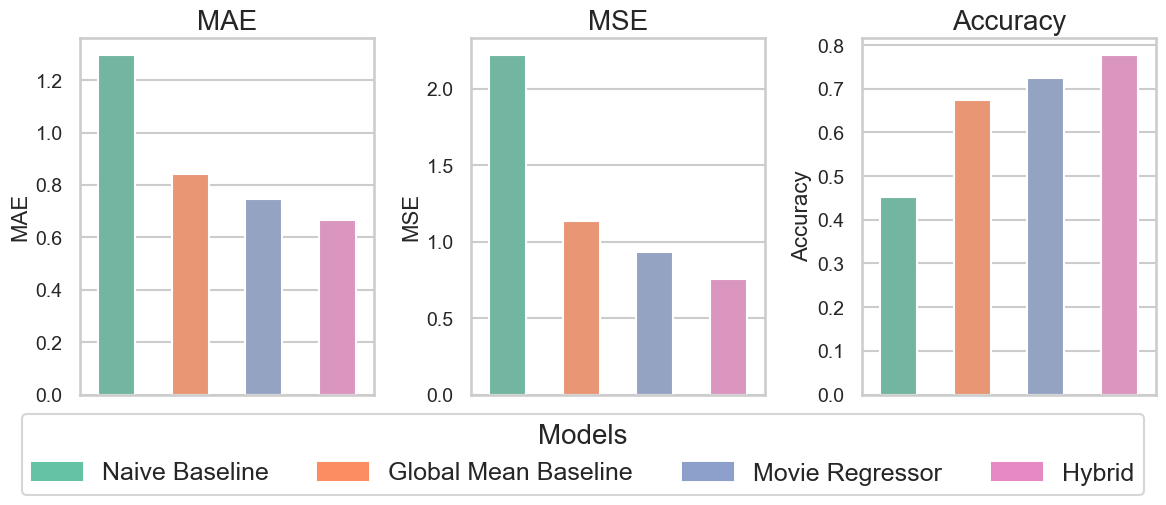

In [10]:
results = [naive_baseline_results, global_mean_baseline_results, movie_regressor_results, hybrid_results]
result_names = ["Naive Baseline", "Global Mean Baseline", "Movie Regressor", "Hybrid"]

data = []
for name, result in zip(result_names, results):
    for metric, value in result.items():
        data.append({"Model": name, "Metric": metric, "Value": value})

df = pd.DataFrame(data)

sns.set(style="whitegrid")
sns.set_context("talk")

colors = sns.color_palette("Set2", len(result_names))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # Adjust width for horizontal layout

sns.barplot(x="Model", y="Value", hue="Model", data=df[df["Metric"] == "mae"], palette=colors, width=0.5, ax=axs[0], dodge=False)
axs[0].set_title("MAE", fontsize=20)
axs[0].set_ylabel("MAE", fontsize=16)
axs[0].set_xlabel("")
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_xticks([])

sns.barplot(x="Model", y="Value", hue="Model", data=df[df["Metric"] == "mse"], palette=colors, width=0.5, ax=axs[1], dodge=False)
axs[1].set_title("MSE", fontsize=20)
axs[1].set_ylabel("MSE", fontsize=16)
axs[1].set_xlabel("")
axs[1].tick_params(axis='y', labelsize=14)
axs[1].set_xticks([])

sns.barplot(x="Model", y="Value", hue="Model", data=df[df["Metric"] == "accuracy"], palette=colors, width=0.5, ax=axs[2], dodge=False)
axs[2].set_title("Accuracy", fontsize=20)
axs[2].set_ylabel("Accuracy", fontsize=16)
axs[2].set_xlabel("")
axs[2].tick_params(axis='y', labelsize=14)
axs[2].set_xticks([])

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = result_names
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=18, title="Models", title_fontsize=20, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=(0.0, 0.1, 1.0, 1.0))
plt.show()